### Facebook Prophet

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import utils
import itertools
import numpy as np
import pandas as pd
import pickle
import os

import statsmodels.api as sm
# import warnings
# warnings.filterwarnings("ignore")

from pylab import rcParams


from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from timeit import default_timer as timer

# prophet preformance
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
json_path = 'init_params.json'

#Hyperopt
from hyperopt import hp, fmin, tpe
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import Trials

params = utils.Params(json_path)

In [11]:
params.model_save_folder_name

'final_models'

In [18]:
params.max_number_of_trials

50

In [12]:
def create_directory(save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
create_directory(os.path.join(params.dataset, params.model_save_folder_name))

In [13]:
df_org = pd.read_csv(params.csv_path)
df_org['Date'] = pd.to_datetime(df_org['Date'].astype(str), format='%Y-%m-%d')
df_org.head(5)

,Date,PM2.5,PM10,SO2,CO,NOx,O3,WS,Temp,RH,RF
0,2013-01-01,240.365653,404.141923,4.0392,0.3567,19.6254,6.5769,1.3795,17.8800,69.8887,0.0583
1,2013-01-02,267.760636,447.535746,3.9436,0.3086,13.4329,4.5049,1.4104,18.6961,67.1973,0.0467
2,2013-01-03,262.088263,449.070512,3.8702,0.3405,16.0926,5.3954,1.6614,20.0829,68.4158,0.0482
3,2013-01-04,222.661851,372.724157,4.2239,0.3858,19.5855,6.5480,1.2790,20.1200,70.4625,0.0226
4,2013-01-05,164.089142,278.164502,4.0392,0.5365,31.8197,10.6209,1.3413,18.7043,62.1733,0.0200


### EDA

In [14]:
df_org.columns = ['ds','y','PM10', 'SO2', 'CO', 'NOx', 'O3', 'WS', 'Temp', 'RH', 'RF']
regressors = ['WS','Temp','RH','RF','NOx','SO2','O3','CO']

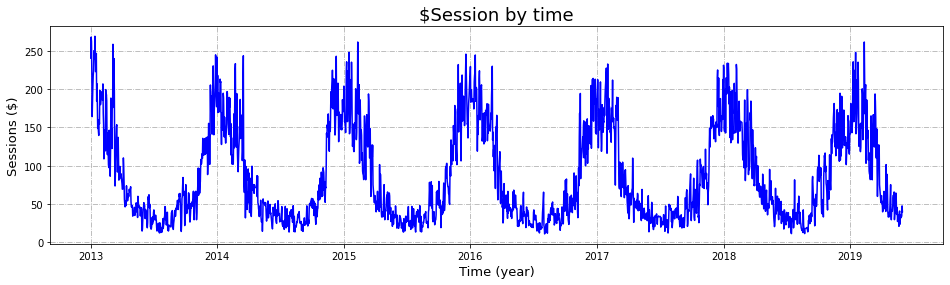

In [15]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(df_org.ds, df_org.y, 'b')

# set title & labels
plt.title('$Session by time', fontsize=18)
plt.ylabel('Sessions ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

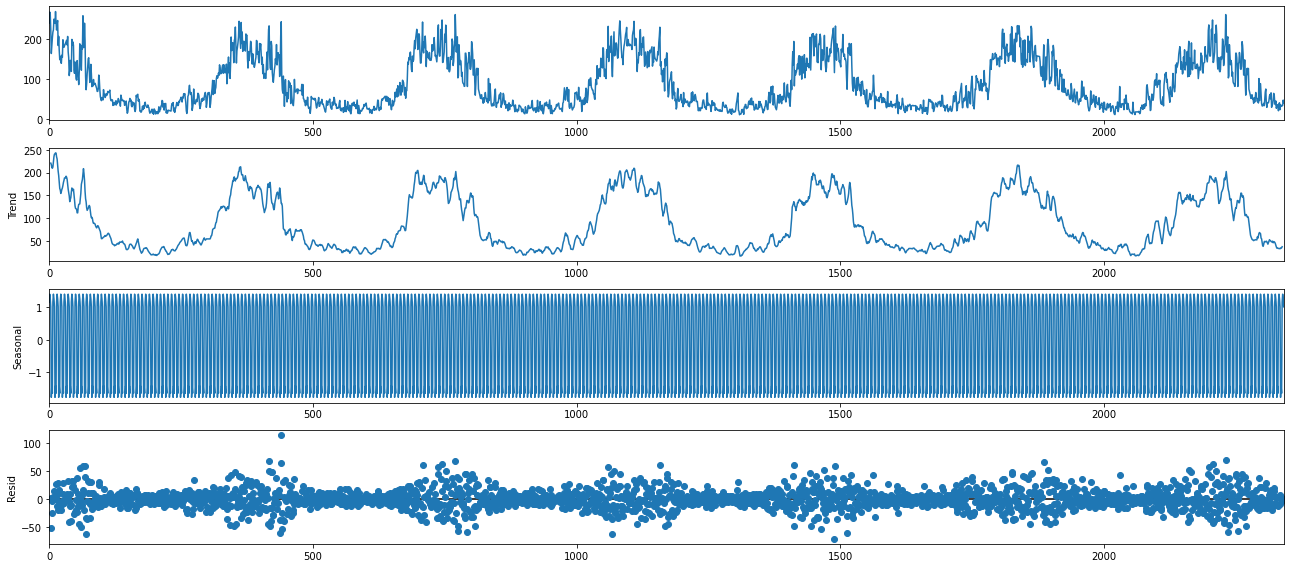

In [16]:
y = df_org[['y']]
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, period = 7)
fig = decomposition.plot()
plt.show()

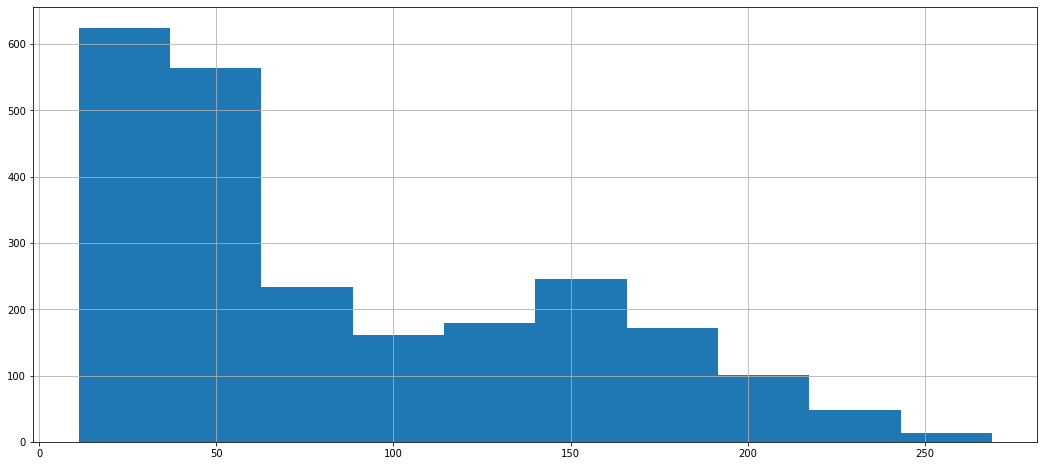

In [9]:
df_org.y.hist()

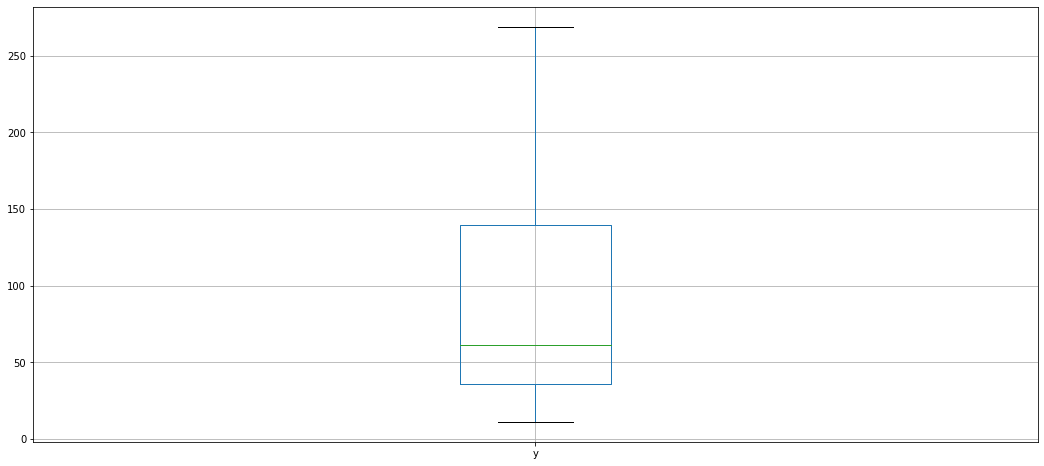

In [15]:
df_org.boxplot(column='y', return_type='axes');
#df_org['y'].hist()


In [16]:
df = df_org.copy()

In [17]:
split_date='2018-12-31'
forecast_days = 365
train = df[df.ds<=datetime.strptime(split_date, '%Y-%m-%d')]
test = df[(df.ds>datetime.strptime(split_date, '%Y-%m-%d')) & (df.ds<datetime.strptime('2019-01-01', '%Y-%m-%d')) ]

In [18]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
#     df['date'] = df.index
#     df['dayofweek'] = df['ds'].dt.dayofweek
#     df['quarter'] = df['ds'].dt.quarter
#     df['month'] = df['ds'].dt.month
#     df['year'] = df['ds'].dt.year
#     df['dayofyear'] = df['ds'].dt.dayofyear
#     df['dayofmonth'] = df['ds'].dt.day
#     df['weekofyear'] = df['ds'].dt.weekofyear

    df['dayofweek_sin'] = np.sin(2*np.pi*df['ds'].dt.dayofweek/7)
    df['dayofweek_cos'] = np.cos(2*np.pi*df['ds'].dt.dayofweek/7)
    df['week_sin'] = np.sin(2*np.pi*df['ds'].dt.weekofyear/52)
    df['week_cos'] = np.cos(2*np.pi*df['ds'].dt.weekofyear/52)
    df['month_sin'] = np.sin(2*np.pi*df['ds'].dt.month/12)
    df['month_cos'] = np.cos(2*np.pi*df['ds'].dt.month/12)
    
#     X = df[['dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]
#     if label:
#         y = df[label]
#         return X, y
    return df


In [19]:
df = create_features(df)
df

e:\data science masters\research\air_quality_data\venv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
e:\data science masters\research\air_quality_data\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,ds,y,PM10,SO2,CO,NOx,O3,WS,Temp,RH,RF,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos
0,2013-01-01,240.365653,404.141923,4.0392,0.3567,19.6254,6.5769,1.3795,17.8800,69.8887,0.0583,0.781831,0.623490,0.120537,0.992709,0.5,0.866025
1,2013-01-02,267.760636,447.535746,3.9436,0.3086,13.4329,4.5049,1.4104,18.6961,67.1973,0.0467,0.974928,-0.222521,0.120537,0.992709,0.5,0.866025
2,2013-01-03,262.088263,449.070512,3.8702,0.3405,16.0926,5.3954,1.6614,20.0829,68.4158,0.0482,0.433884,-0.900969,0.120537,0.992709,0.5,0.866025
3,2013-01-04,222.661851,372.724157,4.2239,0.3858,19.5855,6.5480,1.2790,20.1200,70.4625,0.0226,-0.433884,-0.900969,0.120537,0.992709,0.5,0.866025
4,2013-01-05,164.089142,278.164502,4.0392,0.5365,31.8197,10.6209,1.3413,18.7043,62.1733,0.0200,-0.974928,-0.222521,0.120537,0.992709,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2019-05-27,32.254731,71.798210,2.0623,0.3586,9.6544,3.5816,1.6276,27.5050,71.6983,0.0696,0.000000,1.000000,0.464723,-0.885456,0.5,-0.866025
2338,2019-05-28,33.639295,71.958079,1.4134,0.3457,9.8765,3.3788,1.8658,27.3188,70.9721,0.0709,0.781831,0.623490,0.464723,-0.885456,0.5,-0.866025
2339,2019-05-29,34.567208,71.600328,2.3504,0.3660,8.9842,3.0291,1.8658,28.7150,69.3067,0.0704,0.974928,-0.222521,0.464723,-0.885456,0.5,-0.866025
2340,2019-05-30,47.692519,88.990768,2.4768,0.3999,12.2521,4.1930,0.6333,27.0925,73.8333,0.1246,0.433884,-0.900969,0.464723,-0.885456,0.5,-0.866025


### Prophet optimization with cross validation

#### Optimization

In [18]:
def save_model(path, model):
    with open(path+'/prophet_best.pckl', 'wb') as fout:
        pickle.dump(model, fout)
        
def load_model(path):
    with open(path+'/prophet_best.pckl', 'wb') as fin:
        m2 = pickle.load(fin)
    return m2

In [120]:
# Define the search space
space = {
    #'lstm_layers': hp.quniform('lstm_layers', 1, 3, 1),
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.001, 0.5),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 0.01, 10),
    'holidays_prior_scale': hp.uniform('holidays_prior_scale', 0.01, 10),
    'seasonality_mode': hp.choice('seasonality_mode', ['additive', 'multiplicative'])
}

In [127]:
rmses = []  # Store the RMSEs for each params here
wmt_cv_array = []
best_rmse =  float('inf')

def train_prophet(param, regressors, df):
    
    m = Prophet(interval_width=0.95,\
                changepoint_prior_scale = param.changepoint_prior_scale,\
                seasonality_prior_scale = param.seasonality_prior_scale,\
                holidays_prior_scale = param.holidays_prior_scale,\
                seasonality_mode = param.seasonality_mode,\
                yearly_seasonality=True,\
                weekly_seasonality=True,\
                daily_seasonality = True)
    
    for i in regressors:
        m.add_regressor(i)
        
    m.fit(df[df.ds<'2019-01-01'])#Fit model with given params
    
    wmt_cv = cross_validation(m, initial='1825 days', period='1days', horizon='7 days')
    df_p = performance_metrics(wmt_cv, rolling_window=1)
    #wmt_cv_array.append(wmt_cv)
    
    return m, wmt_cv, df_p['rmse'].values[0]

def objective_fun(param_space):
    
    global best_rmse
    params = utils.Params(json_path)
    # Evaluate the function
    start = timer()
    
    params.changepoint_prior_scale = param_space['changepoint_prior_scale']
    params.seasonality_prior_scale = param_space['seasonality_prior_scale']
    params.holidays_prior_scale = param_space['holidays_prior_scale']
    params.seasonality_mode = param_space['seasonality_mode']
    
    model, prediction_df, loss = train_prophet(params, regressors, df.copy())
    
    if loss<best_rmse:
        save_model(os.path.join(params.dataset, params.model_save_folder_name), model)
        prediction_df.to_csv(os.path.join(params.dataset, params.model_save_folder_name, 'prophet_results.csv'))
        best_rmse = loss
        
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    results = {'loss': loss, 'status': STATUS_OK, \
               'changepoint_prior_scale': param_space['changepoint_prior_scale'], \
               'seasonality_prior_scale': param_space['seasonality_prior_scale'], \
               'holidays_prior_scale': param_space['holidays_prior_scale'], \
               'seasonality_mode': param_space['seasonality_mode'], \
               'time': time_elapsed}
    
    # Return dictionary
    return results

In [128]:
start = timer()

# New trials object
trials = Trials()
# Run 3 evals with the tpe algorithm
best = fmin(fn=objective_fun, space=space, algo=tpe.suggest, trials=trials, 
                max_evals=params.max_number_of_trials, rstate= np.random.RandomState(120))
end = timer()

print("Time Elapsed: ", end-start)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001529 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


  2%|▏         | 1/50 [21:24<17:28:37, 1284.02s/trial, best loss: 27.1796123331684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002043 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 27.179612
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


  4%|▍         | 2/50 [1:18:45<25:44:54, 1931.15s/trial, best loss: 27.1796123331684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 27.179612
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


  6%|▌         | 3/50 [1:53:15<25:45:23, 1972.85s/trial, best loss: 27.1796123331684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001213 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 27.179612
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


  8%|▊         | 4/50 [2:15:06<22:40:22, 1774.40s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001268 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 10%|█         | 5/50 [2:26:42<18:08:06, 1450.82s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001192 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 12%|█▏        | 6/50 [2:43:26<16:05:39, 1316.80s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001211 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 14%|█▍        | 7/50 [3:21:53<19:16:40, 1613.96s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002012 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 16%|█▌        | 8/50 [3:40:02<16:59:28, 1456.39s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001175 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 18%|█▊        | 9/50 [3:52:53<14:14:41, 1250.76s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001208 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 20%|██        | 10/50 [4:19:07<14:58:28, 1347.71s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001282 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 22%|██▏       | 11/50 [4:36:15<13:33:44, 1251.91s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001198 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 24%|██▍       | 12/50 [4:54:20<12:41:06, 1201.75s/trial, best loss: 27.15555021504662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001971 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 27.155550
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 26%|██▌       | 13/50 [5:16:43<12:47:10, 1244.07s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001267 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 28%|██▊       | 14/50 [5:56:06<15:47:49, 1579.71s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001174 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 30%|███       | 15/50 [6:12:56<13:41:52, 1408.92s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001204 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 32%|███▏      | 16/50 [6:32:24<12:37:22, 1336.53s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001233 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 34%|███▍      | 17/50 [6:49:09<11:20:26, 1237.18s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001219 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 36%|███▌      | 18/50 [7:07:11<10:34:55, 1190.50s/trial, best loss: 27.153468212975927]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001184 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 27.153468
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 38%|███▊      | 19/50 [7:29:00<10:33:28, 1226.09s/trial, best loss: 27.151286139174996]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001954 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 27.151286
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 40%|████      | 20/50 [8:07:38<12:56:54, 1553.81s/trial, best loss: 27.151286139174996]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002008 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 27.151286
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 42%|████▏     | 21/50 [8:34:28<12:39:10, 1570.69s/trial, best loss: 27.05490576292348] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002287 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 27.054906
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 44%|████▍     | 22/50 [8:55:58<11:33:37, 1486.33s/trial, best loss: 27.05490576292348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001194 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 27.054906
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 46%|████▌     | 23/50 [9:18:54<10:53:55, 1453.16s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001272 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 48%|████▊     | 24/50 [9:37:48<9:48:18, 1357.63s/trial, best loss: 26.868926279469186] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001169 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 50%|█████     | 25/50 [9:58:43<9:12:51, 1326.88s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001805 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 52%|█████▏    | 26/50 [10:17:29<8:26:33, 1266.38s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001241 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 54%|█████▍    | 27/50 [10:40:04<8:15:41, 1293.09s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001248 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 56%|█████▌    | 28/50 [10:59:52<7:42:34, 1261.58s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001236 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 58%|█████▊    | 29/50 [11:18:06<7:03:55, 1211.20s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001970 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 60%|██████    | 30/50 [11:39:20<6:49:59, 1229.97s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001937 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 62%|██████▏   | 31/50 [11:58:54<6:24:11, 1213.22s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001190 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 64%|██████▍   | 32/50 [12:36:19<7:36:53, 1522.96s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001199 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 66%|██████▌   | 33/50 [12:57:35<6:50:26, 1448.61s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001148 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 68%|██████▊   | 34/50 [13:15:46<5:57:41, 1341.32s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001343 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 70%|███████   | 35/50 [13:55:24<6:53:07, 1652.50s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001316 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 72%|███████▏  | 36/50 [14:15:22<5:53:43, 1515.98s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001235 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 74%|███████▍  | 37/50 [14:34:42<5:05:19, 1409.23s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001183 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 76%|███████▌  | 38/50 [14:53:01<4:23:15, 1316.26s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001190 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 78%|███████▊  | 39/50 [15:29:15<4:48:27, 1573.44s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001953 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 80%|████████  | 40/50 [15:51:31<4:10:24, 1502.42s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001199 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 82%|████████▏ | 41/50 [16:27:01<4:13:35, 1690.66s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001472 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 84%|████████▍ | 42/50 [16:47:34<3:27:06, 1553.28s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001158 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 86%|████████▌ | 43/50 [17:02:01<2:37:11, 1347.39s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001142 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 88%|████████▊ | 44/50 [17:19:26<2:05:40, 1256.74s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001958 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 90%|█████████ | 45/50 [17:33:36<1:34:33, 1134.63s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001105 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 92%|█████████▏| 46/50 [17:52:13<1:15:17, 1129.31s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001345 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 94%|█████████▍| 47/50 [18:14:15<59:21, 1187.14s/trial, best loss: 26.868926279469186]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001144 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 96%|█████████▌| 48/50 [18:53:08<51:02, 1531.07s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001237 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


 98%|█████████▊| 49/50 [19:11:09<23:16, 1396.07s/trial, best loss: 26.868926279469186]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002098 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss 26.868926
INFO:fbprophet:Making 359 forecasts with cutoffs between 2017-12-31 00:00:00 and 2018-12-24 00:00:00


100%|██████████| 50/50 [19:31:09<00:00, 1405.39s/trial, best loss: 26.868926279469186]


In [129]:
# Results into a dataframe
results = trials.results
results_df = pd.DataFrame({'time': [x['time'] for x in results],
                           'changepoint_prior_scale': [x['changepoint_prior_scale'] for x in results],
                           'seasonality_prior_scale': [x['seasonality_prior_scale'] for x in results],
                           'holidays_prior_scale': [x['holidays_prior_scale'] for x in results],
                           'seasonality_mode': [x['seasonality_mode'] for x in results],
                           'loss': [x['loss'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()

,time,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,loss,iteration
22,1375.748112,0.415356,0.017457,8.534135,additive,26.868926,22
20,1610.068800,0.486524,0.036358,9.766176,additive,27.054906,20
29,1273.756096,0.445326,0.036851,9.512480,additive,27.058571,29
24,1255.116876,0.433172,0.097348,8.601989,additive,27.138414,24
18,1309.131902,0.469848,5.099994,8.016793,additive,27.151286,18


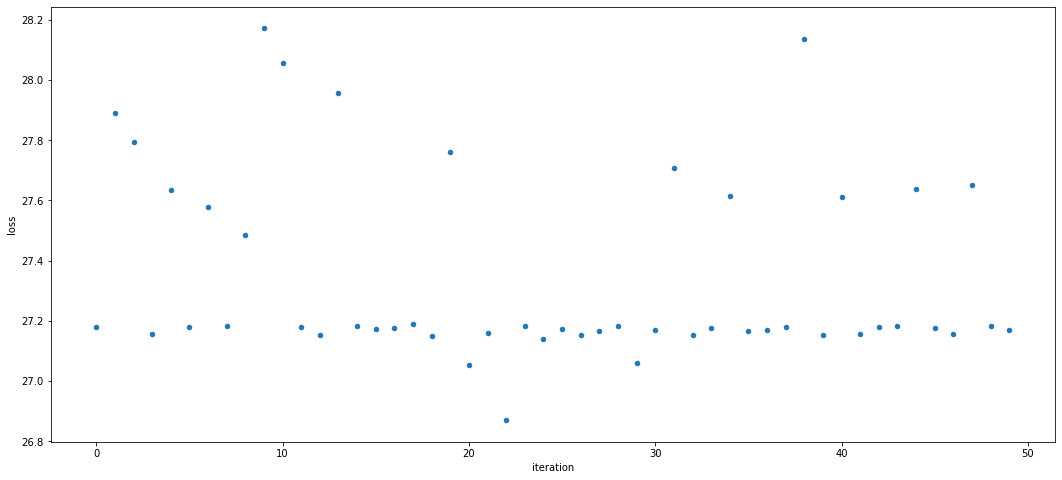

In [130]:
results_df.plot.scatter(x='iteration', y ='loss')

In [22]:
wmt_cv = pd.read_csv(params.dataset+'//'+params.model_save_folder_name+'/prophet_results.csv')

wmt_cv['ds'] = pd.to_datetime(wmt_cv['ds'].astype(str), format='%Y-%m-%d')
wmt_cv['cutoff'] = pd.to_datetime(wmt_cv['cutoff'].astype(str), format='%Y-%m-%d')
wmt_cv['horizon'] = wmt_cv.ds - wmt_cv.cutoff

In [23]:
performance_metrics(wmt_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,721.939199,26.868926,20.925131,0.335675,0.229483,0.872662


#### Evaluate on test set

##### MAE

In [24]:
total_len = len(wmt_cv.groupby('cutoff').apply(lambda x: mean_absolute_error(x.y, x.yhat)))
mae_per_sample = wmt_cv.groupby('cutoff').apply(lambda x: mean_absolute_error(x.y, x.yhat)).sum()/total_len
print('MAE per sample: ', mae_per_sample)

# Calculate MAE over all folds at each horizon
wmt_cv.groupby('horizon').apply(lambda x: mean_absolute_error(x.y, x.yhat))

MAE per sample:  20.925130838992146


horizon
1 days    20.287188
2 days    20.515695
3 days    20.708260
4 days    20.943320
5 days    21.183981
6 days    21.355709
7 days    21.481763
dtype: float64

##### RMSE

In [138]:
total_len = len(wmt_cv.groupby('cutoff').apply(lambda x: mean_squared_error(x.y, x.yhat, squared=False)))
rmse_per_sample = wmt_cv.groupby('cutoff').apply(lambda x: mean_squared_error(x.y, x.yhat, squared=False)).sum()/total_len
print('RMSE per sample: ', rmse_per_sample)

# Calculate RMSE over all folds at each horizon
wmt_cv.groupby('horizon').apply(lambda x: mean_squared_error(x.y, x.yhat, squared=False))

RMSE per sample:  24.196170690458995


horizon
1 days    25.986672
2 days    26.281888
3 days    26.521793
4 days    26.911092
5 days    27.249834
6 days    27.445912
7 days    27.642101
dtype: float64